In [229]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from pyomo.environ import *
from optimization_utils import *
from param_loader import METANET_Params
from simulation_utils import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [230]:
# rho_hat = df["Density"]
# q_hat = df["Flow"]
# print(max(q_hat))
# C_i = np.mean(sorted(q_hat)[-5:])
# print("C_i", C_i)
# K = len(rho_hat)

RESULTS_DIR = "calibration_results"

q_hat = np.load("data/flow_10sec_400m_1hr.npy")
print(np.max(q_hat))
rho_hat = np.load("data/density_10sec_400m_1hr.npy")
v_hat = q_hat / rho_hat
print(rho_hat.shape)
flattened_q_hat = q_hat.flatten()
print(max(flattened_q_hat))
flattened_rho_hat = rho_hat.flatten()
C_i = np.mean(np.sort(flattened_q_hat)[-5:])
print("C_i", C_i)
K = len(flattened_rho_hat)
print("K", K)

6773.200199999966
(360, 16)
6773.200199999966
C_i 6718.716719999977
K 5760


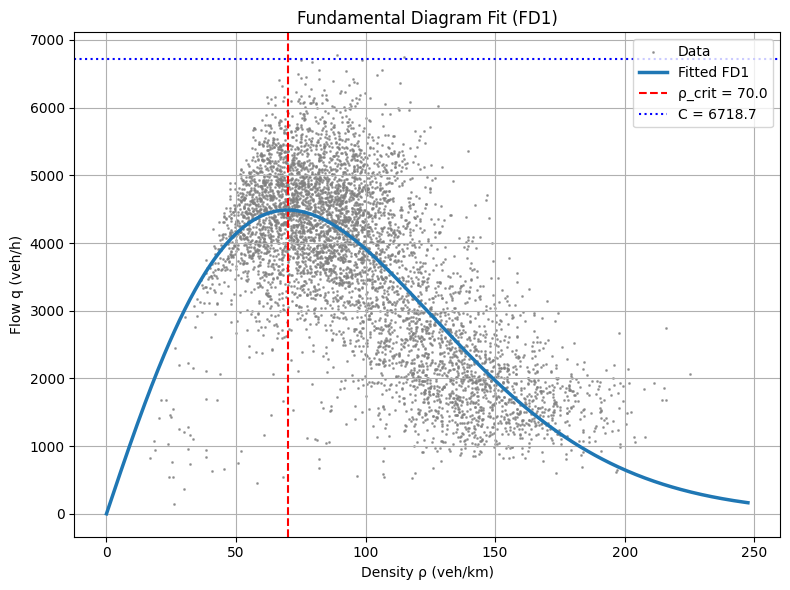

{'rho_crit': 69.95774856112287, 'V_free': 114.25733457721735, 'a': 1.7319895914943968, 'C': np.float64(6718.716719999977), 'Q_fd1': <function fit_fd1.<locals>.Q_fd1 at 0x140f2ca90>}


In [231]:
params = fit_fd1(flattened_rho_hat, flattened_q_hat)
print(params)

In [232]:
rho_hat = np.where(rho_hat == 0.0, 1e-3, rho_hat)
q_hat = np.where(q_hat == 0.0, 1e-3, q_hat)
# v_hat = q_hat / rho_hat
# v_hat = np.where(v_hat == 0.0, 1e-3, v_hat)

In [233]:
random.seed(1)

T = 10 / 3600
l = 0.4
num_calibrated_segments = 14
include_ramping = False
varylanes = False
# lane_mapping = np.array([4 if i < num_calibrated_segments - 4 else 2 for i in range(num_calibrated_segments)])

results = run_calibration(
    rho_hat,
    q_hat,
    T,
    l,
    num_calibrated_segments=num_calibrated_segments,
    varylanes=varylanes,
    include_ramping=include_ramping,
    smoothing=True
)

1 15
360 14
(360, 1)
(360, 1)
Ipopt 3.14.16: max_iter=20000
acceptable_constr_viol_tol=1e-12
constr_viol_tol=1e-12


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.16, running with linear solver MUMPS 5.6.2.

Number of nonzeros in equality constraint Jacobian...:    79008
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:    78859

Total number of variables............................:    15204
                     variables with only lower bounds:        0
                variables with lower and upper bounds:    15204
                     variables with only

In [217]:
# Save initial and downstream conditions
np.save(f"{RESULTS_DIR}/upstream_flow.npy", q_hat[:, 0])
np.save(f"{RESULTS_DIR}/downstream_density.npy", rho_hat[:, -1])

In [218]:
tau_array = results["tau"]
K_array = results["K"]
eta_high_array = results["eta_high"]
rho_crit_array = results["rho_crit"]
v_free_array = results["v_free"]
a_array = results["a"]
num_lanes_array = results["num_lanes"]
if include_ramping:
    # gamma_array = results["gamma"]
    beta_array = results["beta"]
    r_inflow_array = results["r_inflow"]

In [219]:
# r_array = np.zeros(num_calibrated_segments)
# beta_array = np.zeros(num_calibrated_segments)
# print(beta_array.shape)
# print(r_inflow_array.shape)

In [220]:
# Save everything
v_pred_array = results["v_pred"]
rho_pred_array = results["rho_pred"]
q_array = v_pred_array * rho_pred_array
np.save(f"{RESULTS_DIR}/tau.npy", tau_array)
np.save(f"{RESULTS_DIR}/K.npy", K_array)
np.save(f"{RESULTS_DIR}/eta_high.npy", eta_high_array)
np.save(f"{RESULTS_DIR}/rho_crit.npy", rho_crit_array)
np.save(f"{RESULTS_DIR}/v_free.npy", v_free_array)
np.save(f"{RESULTS_DIR}/a.npy", a_array)
np.save(f"{RESULTS_DIR}/num_lanes.npy", num_lanes_array)
np.save(f"{RESULTS_DIR}/q_pred.npy", q_array)
np.save(f"{RESULTS_DIR}/v_pred.npy", v_pred_array)
np.save(f"{RESULTS_DIR}/rho_pred.npy", rho_pred_array)
# np.save("r_array.npy", r_array)
if include_ramping:
    # np.save("gamma_array.npy", gamma_array)
    np.save(f"{RESULTS_DIR}/beta_array.npy", beta_array)
    np.save(f"{RESULTS_DIR}/r_inflow_array.npy", r_inflow_array)

(360, 14)


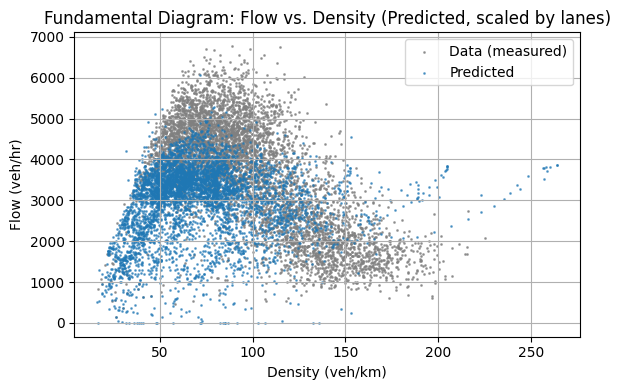

In [221]:
import matplotlib.pyplot as plt

# # Collect scaled predictions across all segments
all_rho_pred = rho_pred_array

print(all_rho_pred.shape)
all_v_pred = v_pred_array
all_q_pred = all_rho_pred * all_v_pred


# Stack predictions
all_rho_pred = np.hstack(all_rho_pred)
all_q_pred = np.hstack(all_q_pred)
all_v_pred = np.hstack(all_v_pred)

assert np.all(v_pred_array[0,:] == v_hat[0,1:-1])
assert np.all(v_pred_array[0,:] == v_hat[0,1:-1])
# Plot
plt.figure(figsize=(6, 4))
plt.scatter(rho_hat, q_hat, color="gray", alpha=0.7, s=1, label="Data (measured)")
plt.scatter(all_rho_pred, all_q_pred, alpha=0.6, s=1, label="Predicted")
plt.xlabel("Density (veh/km)")
plt.ylabel("Flow (veh/hr)")
plt.title("Fundamental Diagram: Flow vs. Density (Predicted, scaled by lanes)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

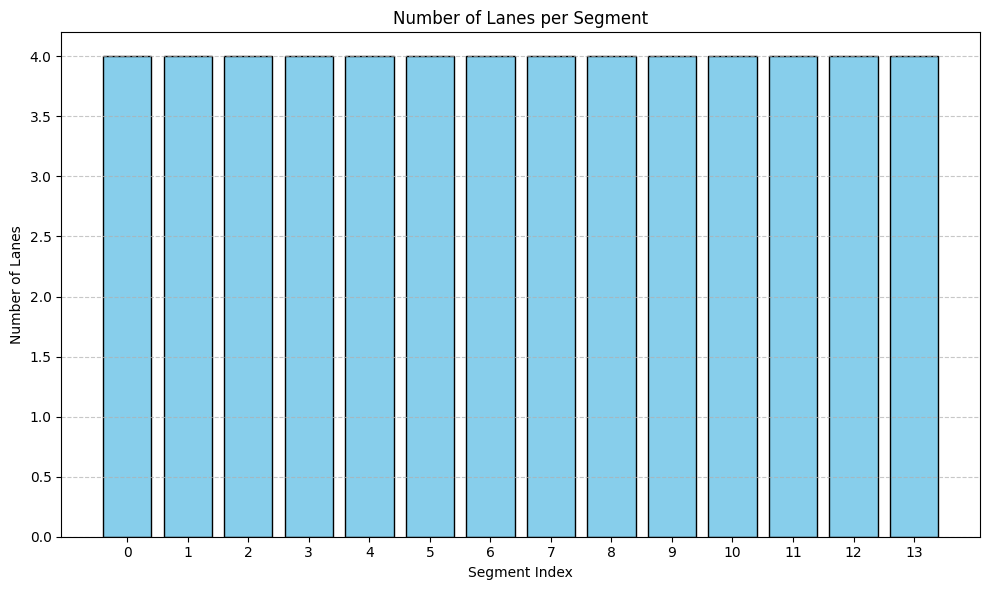

In [222]:
plt.figure(figsize=(10, 6))
plt.bar(
    np.arange(len(num_lanes_array)), num_lanes_array, color="skyblue", edgecolor="black"
)

plt.xlabel("Segment Index")
plt.ylabel("Number of Lanes")
plt.title("Number of Lanes per Segment")
plt.xticks(np.arange(len(num_lanes_array)))  # show all indices
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.tight_layout()

In [223]:
if include_ramping:
    plt.figure(figsize=(10, 6))
    plt.bar(
        np.arange(len(r_inflow_array)), r_inflow_array, color="skyblue", edgecolor="black"
    )

    plt.xlabel("Segment Index")
    plt.ylabel("Inflow")
    plt.title("Inflow per Segment")
    plt.xticks(np.arange(len(num_lanes_array)))  # show all indices
    plt.grid(axis="y", linestyle="--", alpha=0.7)

    plt.tight_layout()

In [224]:
if include_ramping:
    plt.figure(figsize=(10, 6))
    plt.bar(np.arange(len(beta_array)), beta_array, color="skyblue", edgecolor="black")

    plt.xlabel("Segment Index")
    plt.ylabel("Inflow")
    plt.title("Beta per Segment")
    plt.xticks(np.arange(len(num_lanes_array)))  # show all indices
    plt.grid(axis="y", linestyle="--", alpha=0.7)

    plt.tight_layout()

In [225]:
print(all_v_pred.shape)
q_array = rho_pred_array * v_pred_array
print("rho mape", mape(rho_hat[:, 1:-1], rho_pred_array))
print("q mape", mape(q_hat[:, 1:-1], q_array))
print("v mape", mape(v_hat[:, 1:-1], v_pred_array))
print("----------------")
print("rho rmse", rmse(rho_hat[:, 1:-1], rho_pred_array))
print("q rmse", rmse(q_hat[:, 1:-1], q_array))
print("v rmse", rmse(v_hat[:, 1:-1], v_pred_array))

(5040,)
rho mape 33.68015813356109
q mape 37.857489505465644
v mape 69.7614533033179
----------------
rho rmse 46.142636700743
q rmse 1437.7927155622351
v rmse 21.381629623946154


In [226]:
print("Simulating with calibrated parameters...")

# Scale densities per lane for simulation
scaled_rho_hat = rho_hat[:, 1:-1] / np.array(num_lanes_array)


# if smoothing boundary conditions
downstream_density = smooth_inflow(rho_hat[:, -1]) / num_lanes_array[-1]
data_inflow = smooth_inflow(q_hat[:, 0])
# downstream_density = rho_hat[:, -1] / num_lanes_array[-1]
# data_inflow = q_hat[:, 0]
# print(downstream_density[250:270])
# print(rho_hat[250:270, -1])

print(np.where(scaled_rho_hat < 0))
# Sim requires tuple of initial conditions: density, velocity, inflow, and queue
init_traffic_state = (scaled_rho_hat[0, :], v_hat[0, 1:-1], data_inflow[0], 0)
params = METANET_Params(path=RESULTS_DIR, num_segments=num_calibrated_segments).get_params()
rho_sim, v_sim, _, tts_sim = run_metanet_sim(
    T, 
    l, 
    init_traffic_state,
    data_inflow,
    downstream_density,
    params,
    vsl_speeds=None,
    lanes={i: num_lanes_array[i] for i in range(num_calibrated_segments)},
    plotting=True,
    real_data=True
)

print(rho_pred_array[230:270, -1])
print(rho_sim[230:270, -1] * 4)

Simulating with calibrated parameters...
(array([], dtype=int64), array([], dtype=int64))
360 14
[ 60.77623398  58.20461063  58.55967744  60.9425893   62.35698994
  61.93977643  61.06220948  61.40988626  63.4848976   65.82483476
  66.65632415  66.57012931  68.12466115  72.09408133  76.97370792
  81.09285742  84.81407826  89.00043945  94.43056616 102.1818479
 110.42670475 117.32470495 123.53055479 129.76446717 135.63959964
 139.80932355 141.31781017 140.10703175 136.61893628 129.92016776
 120.31373304 110.4973178  103.54329794 100.67290196 101.18400688
 102.51704557 100.65009096  95.0659179   89.76763609  86.68695056]
[ 50.82209671  44.83731246  42.84512002  46.04425009  52.22096306
  54.44564046  50.2606218   45.49799778  45.86469131  54.26938155
  64.11136272  63.27900913  55.45790055  49.9857735   52.07486496
  64.79336529  82.46580572  90.76974542  88.92694625  85.16186314
  84.12398917  90.56298944 109.36370244 133.59076611 151.6484517
 158.83059163 153.75086369 144.07244661 131.88

Pred shape: (360, 14)
True shape: (360, 14)
Max true density: 225.06999625000026


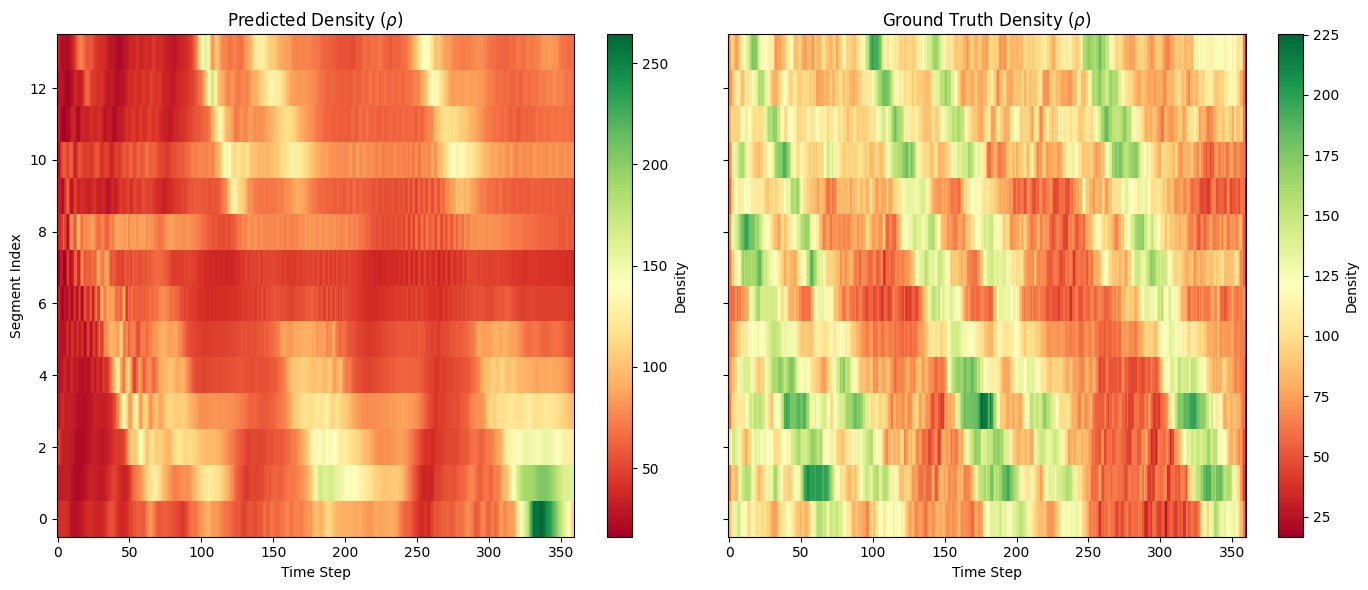

In [227]:
rho_plot_pred = rho_pred_array
rho_plot_true = rho_hat[:, 1:-1]

print("Pred shape:", rho_plot_pred.shape)
print("True shape:", rho_plot_true.shape)
print("Max true density:", np.max(rho_plot_true))

fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# --- Prediction ---
im0 = axes[0].imshow(
    rho_plot_pred.T, aspect="auto", origin="lower", cmap="RdYlGn", interpolation="none"
)
axes[0].set_xlabel("Time Step")
axes[0].set_ylabel("Segment Index")
axes[0].set_title("Predicted Density ($\\rho$)")
fig.colorbar(im0, ax=axes[0], label="Density")

# --- Ground Truth ---
im1 = axes[1].imshow(
    rho_plot_true.T, aspect="auto", origin="lower", cmap="RdYlGn", interpolation="none"
)
axes[1].set_xlabel("Time Step")
axes[1].set_title("Ground Truth Density ($\\rho$)")
fig.colorbar(im1, ax=axes[1], label="Density")

plt.tight_layout()
plt.show()

[15.60562109 22.63969379 14.53123911 33.0528382  44.74894381 40.31822336
 36.43426698 50.4408325  24.55019846 12.00645115  5.34702448 21.88636564
 40.55200066 44.41112619]
[26.73751658 37.74451162 36.92749812 39.26452367 47.95637662 68.05656871
 72.38217369 55.32535987 25.67628792 43.0193491   1.39815937 31.78545322
 34.75546168 62.91981985]
Pred shape: (360, 14)
True shape: (360, 14)
Max true density: 102.5494591064967


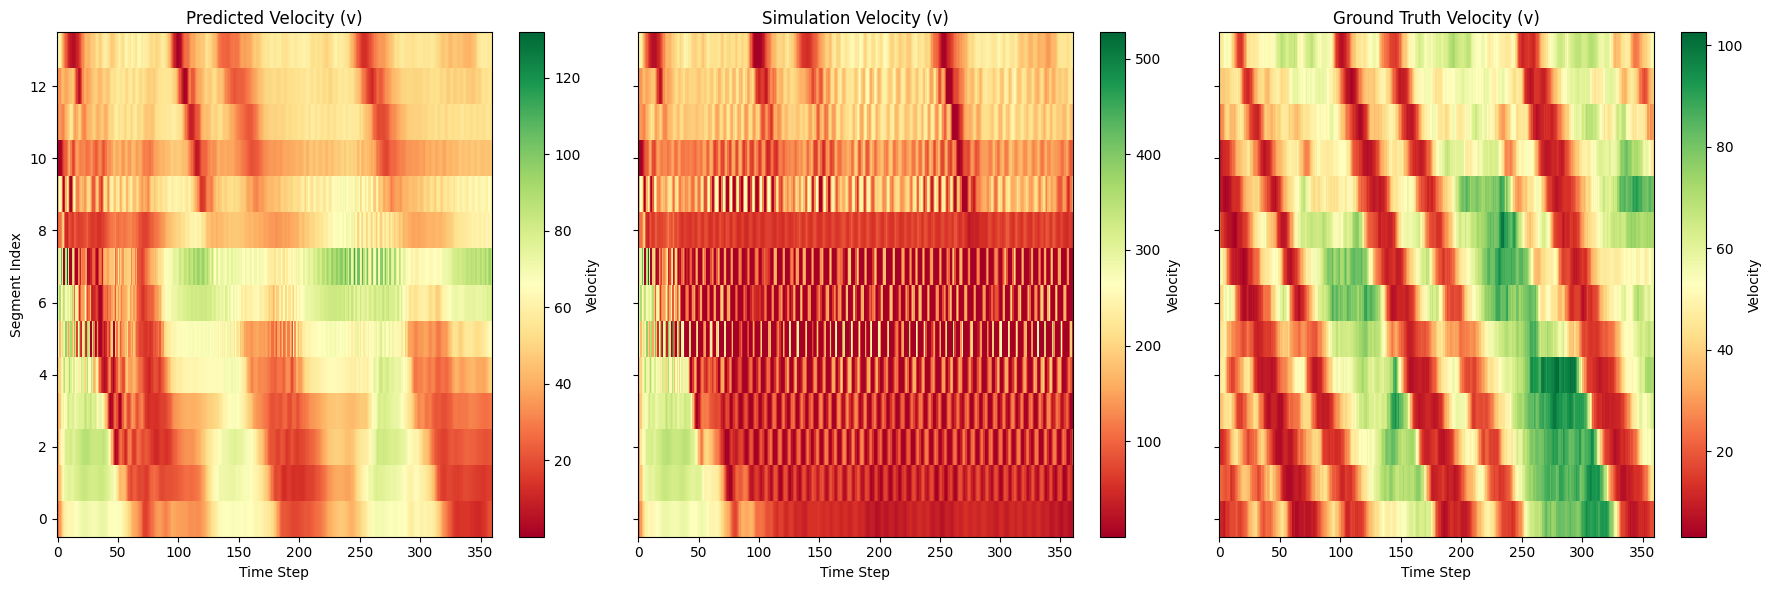

In [228]:
print(v_pred_array[0, :])
print(v_pred_array[1, :])
v_plot_pred = v_pred_array
v_plot_true = v_hat[:, 1:-1]

print("Pred shape:", v_plot_pred.shape)
print("True shape:", v_plot_true.shape)
print("Max true density:", np.max(v_plot_true))

fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

# --- Prediction ---
im0 = axes[0].imshow(
    v_plot_pred.T, aspect="auto", origin="lower", cmap="RdYlGn", interpolation="none"
)
axes[0].set_xlabel("Time Step")
axes[0].set_ylabel("Segment Index")
axes[0].set_title("Predicted Velocity (v)")
fig.colorbar(im0, ax=axes[0], label="Velocity")

# --- Simulation ---
im1 = axes[1].imshow(
    v_sim.T * 4, aspect="auto", origin="lower", cmap="RdYlGn", interpolation="none"
)
axes[1].set_xlabel("Time Step")
axes[1].set_title("Simulation Velocity (v)")
fig.colorbar(im1, ax=axes[1], label="Velocity")


# --- Ground Truth ---
im2 = axes[2].imshow(
    v_plot_true.T, aspect="auto", origin="lower", cmap="RdYlGn", interpolation="none"
)
axes[2].set_xlabel("Time Step")
axes[2].set_title("Ground Truth Velocity (v)")
fig.colorbar(im2, ax=axes[2], label="Velocity")

plt.tight_layout()
plt.show()

In [133]:
print(downstream_density[249:270])
print(smooth_inflow(rho_hat[249:270, -1])/num_lanes_array[-1])

[34.81083235 35.16499915 34.00999892 33.55999879 32.88749873 32.15166562
 30.75666585 28.45749937 26.53416592 23.78749927 21.92583262 18.96999937
 18.33416577 18.55166558 19.39249885 19.11499904 18.98666573 18.69333233
 19.25666563 19.30749902 19.46249906]
[36.02916587 35.16499915 34.00999892 33.55999879 32.88749873 32.15166562
 30.75666585 28.45749937 26.53416592 23.78749927 21.92583262 18.96999937
 18.33416577 18.55166558 19.39249885 19.11499904 18.98666573 18.69333233
 19.25666563 19.30749902 19.97249917]


/var/folders/kl/txwf6c7d73v3xczbyqm3trhw0000gn/T/ipykernel_18604/69037064.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


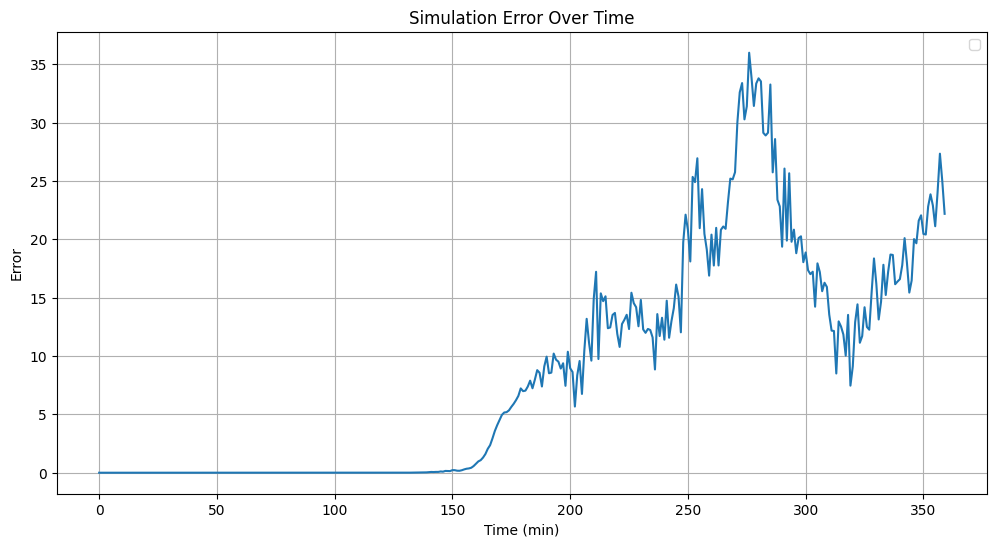

In [134]:
# plot error over time between prediction and simulation
plt.figure(figsize=(12, 6))
plt.plot(np.abs(v_plot_pred - v_sim[0:-1, :]).mean(axis=1))
plt.xlabel('Time (min)')
plt.ylabel('Error')
plt.title('Simulation Error Over Time')
plt.legend()
plt.grid()
plt.show()

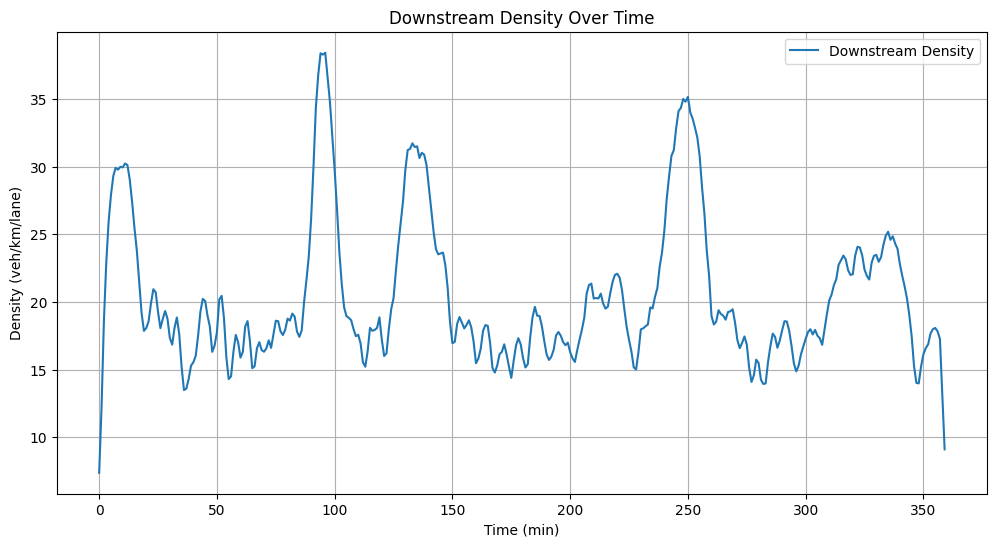

In [135]:
#plot downstream density over time and inflow over time
plt.figure(figsize=(12, 6))
plt.plot(downstream_density, label='Downstream Density')
plt.xlabel('Time (min)')
plt.ylabel('Density (veh/km/lane)')
plt.title('Downstream Density Over Time')
plt.legend()
plt.grid()
plt.show()



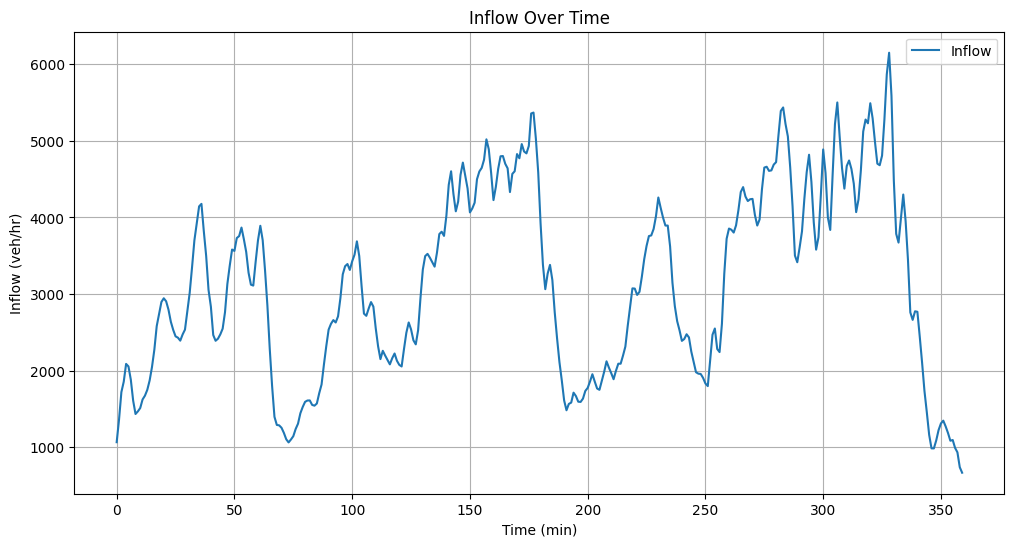

In [136]:
# Plot inflow over time
plt.figure(figsize=(12, 6))
plt.plot(data_inflow, label='Inflow')
plt.xlabel('Time (min)')
plt.ylabel('Inflow (veh/hr)')
plt.title('Inflow Over Time')
plt.legend()
plt.grid()
plt.show()

In [ ]:
rho_plot_pred = rho_pred_array * v_pred_array
rho_plot_true = q_hat[:, 1:-1]

print("Pred shape:", rho_plot_pred.shape)
print("True shape:", rho_plot_true.shape)
print("Max true density:", np.max(rho_plot_true))

fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# --- Prediction ---
im0 = axes[0].imshow(
    rho_plot_pred.T, aspect="auto", origin="lower", cmap="RdYlGn", interpolation="none"
)
axes[0].set_xlabel("Time Step")
axes[0].set_ylabel("Segment Index")
axes[0].set_title("Predicted Flow ($\\rho$)")
fig.colorbar(im0, ax=axes[0], label="Flow")

# --- Ground Truth ---
im1 = axes[1].imshow(
    rho_plot_true.T, aspect="auto", origin="lower", cmap="RdYlGn", interpolation="none"
)
axes[1].set_xlabel("Time Step")
axes[1].set_title("Ground Truth Flow ($\\rho$)")
fig.colorbar(im1, ax=axes[1], label="Flow")

plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


def smooth_inflow(inflow, window_size=2):
    kernel = np.ones(window_size) / window_size
    smoothed = np.apply_along_axis(
        lambda m: np.convolve(m, kernel, mode="same"), axis=0, arr=inflow
    )
    return smoothed


# Example input arrays (replace with your real q_hat and rho_hat)
# timesteps = 100
# q_hat = np.random.uniform(500, 1000, size=(timesteps, 5))   # flow [veh/h]
# rho_hat = np.random.uniform(10, 50, size=(timesteps, 5))    # density [veh/km]

# Apply smoothing
initial_flow = smooth_inflow(q_hat[:, 0:1])  # upstream inflow
downstream_density = smooth_inflow(rho_hat[:, -1:])  # downstream density

# Plotting
plt.figure(figsize=(12, 5))

# Flow vs timesteps
plt.subplot(1, 2, 1)
plt.plot(initial_flow, label="Initial Flow (smoothed)")
plt.xlabel("Timestep")
plt.ylabel("Flow [veh/h]")
plt.title("Upstream Inflow vs Timesteps")
plt.legend()

# Density vs timesteps
plt.subplot(1, 2, 2)
plt.plot(downstream_density, color="orange", label="Downstream Density (smoothed)")
plt.xlabel("Timestep")
plt.ylabel("Density [veh/km]")
plt.title("Downstream Density vs Timesteps")
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
def get_velocity_heatmap(v_hat, v_pred, q_hat, q_pred, rho_hat, rho_pred):
    shortened_v_hat = v_hat[:, 1:-1]
    shortened_rho_hat = rho_hat[:, 1:-1]
    shortened_q_hat = q_hat[:, 1:-1]
    # Determine some set of 3 scalars for each of q, rho, v to make a unified map
    v_diff = (shortened_v_hat - v_pred) / np.max(shortened_v_hat)
    rho_diff = (shortened_rho_hat - rho_pred) / np.max(shortened_rho_hat)
    q_diff = (shortened_q_hat - q_pred) / np.max(shortened_q_hat)

    diff = v_diff + rho_diff + q_diff
    fig, ax = plt.subplots(figsize=(14, 6))

    im = ax.imshow(
        diff.T,
        aspect="auto",
        origin="lower",
        cmap="viridis",
        interpolation="none",
        vmin=0,
    )
    ax.set_xlabel("Time Step")
    ax.set_ylabel("Segment Index")
    ax.set_title("Absolute Inflow Difference |Pred - True|")
    fig.colorbar(im, ax=ax, label="|Flow Difference|")
    plt.show()


get_velocity_heatmap(v_hat, v_pred_array, q_hat, q_array, rho_hat, rho_pred_array)